# Pipeline walkthrough

## Data import

In [1]:
from preprocessing.import_data import import_save_dataset

import napari

trim_series = True
lif_test_name = "test_data/2021-06-14/p2pdpwt"
lsm_test_name = "test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1"

(
    channels_full_dataset,
    original_global_metadata,
    original_frame_metadata,
    export_global_metadata,
    export_frame_metadata,
) = import_save_dataset(lsm_test_name, trim_series=trim_series, mode="tiff")

/home/ybadal/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '
/home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/collated_dataset/collated_dataset_ch00.tiff is a low contrast image
  imsave(collated_data_path, channel_data, plugin="tifffile")
/home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/collated_dataset/collated_dataset_ch01.tiff is a low contrast image
  imsave(collated_data_path

In [67]:
nuclear_channel_metadata = export_frame_metadata[1]
nuclear_channel = channels_full_dataset[1]

In [4]:
viewer = napari.view_image(nuclear_channel, name="Nuclear Channel")
napari.run()

## Starting a Dask Client for parallelization

In [2]:
from nuclear_analysis import segmentation
from tracking import track_features, detect_mitosis

import numpy as np
from dask.distributed import LocalCluster, Client

In [122]:
cluster = LocalCluster(
    host="localhost",
    scheduler_port=8786,
    threads_per_worker=1,
    n_workers=12,
    memory_limit="4GB",
)

In [123]:
client = Client(cluster)

In [124]:
client

<Client: 'tcp://127.0.0.1:8786' processes=12 threads=12, memory=44.70 GiB>

## Nuclear segmentation and tracking

In [125]:
%%time

(
    denoised,
    denoised_futures,
    nuclear_channel_futures,
) = segmentation.denoise_movie_parallel(
    nuclear_channel,
    denoising="gaussian",
    denoising_sigma=3,
    client=client,
)

mask, mask_futures, _ = segmentation.binarize_movie_parallel(
    denoised_futures,
    thresholding="global_otsu",
    closing_footprint=segmentation.ellipsoid(3, 3),
    client=client,
    futures_in=False,
)

markers, markers_futures, _ = segmentation.mark_movie_parallel(
    *nuclear_channel_futures,  # Wrapped in list from previous parallel run, needs unpacking
    mask_futures,
    low_sigma=[3, 5.5, 5.5],
    high_sigma=[10, 14.5, 14.5],
    max_footprint=((1, 25), segmentation.ellipsoid(3, 3)),
    max_diff=1,
    client=client,
    futures_in=False,
)

marker_coords = np.array(np.nonzero(markers)).T

labels, labels_futures, _ = segmentation.segment_movie_parallel(
    denoised_futures,
    markers_futures,
    mask_futures,
    watershed_method="raw",
    min_size=200,
    client=client,
    futures_in=False,
)

segmentation_dataframe = track_features.segmentation_df(
    labels,
    nuclear_channel,
    nuclear_channel_metadata,
)

tracked_dataframe = track_features.link_df(
    segmentation_dataframe,
    search_range=15,
    # adaptive_stop=1,
    # adaptive_step=0.99,
    memory=0,
    pos_columns=["x", "y"],
    t_column="frame_reverse",
    velocity_predict=True,
    velocity_averaging=2,
)

centroids = np.unique(
    np.array(
        [
            [row["frame"] - 1, int(row["z"]), int(row["y"]), int(row["x"])]
            for _, row in tracked_dataframe.iterrows()
        ]
    ),
    axis=0,
)

mitosis_dataframe = detect_mitosis.construct_lineage(
    tracked_dataframe,
    pos_columns=["y", "x"],
    search_range_mitosis=35,
    # adaptive_stop=0.05,
    # adaptive_step=0.99,
    antiparallel_coordinate="collision",
    antiparallel_weight=None,
    min_track_length=3,
    image_dimensions=[256, 512],
    exclude_border=0.02,
    minimum_age=8,
)

reordered_labels, reordered_labels_futures, _ = track_features.reorder_labels_parallel(
    labels_futures,
    mitosis_dataframe,
    client=client,
    futures_in=False,
    futures_out=True,
)

Frame 2: 1 trajectories present.
CPU times: user 50.1 s, sys: 27 s, total: 1min 17s
Wall time: 3min 5s


Using the rule of thumb $r \approx \sigma \sqrt{2} \ (2D)$ and $r \approx \sigma \sqrt{3} \ (3D)$ as rough bounds for the kernels used for band-pass filtering seems to net a perfect segmentation.

In [9]:
viewer.add_labels(reordered_labels)

<Labels layer 'reordered_labels' at 0x7fbedc5db760>

In [10]:
_ = detect_mitosis.tracks_to_napari(
    viewer, mitosis_dataframe, name="nuclear_tracks", output=False
)

## Spot segmentation and fitting

In [6]:
transcription_channel_metadata = export_frame_metadata[0]
transcription_channel = channels_full_dataset[0]

In [45]:
viewer = napari.view_image(transcription_channel, name="Transcription Channel")
napari.run()

In [7]:
from spot_analysis import detection, fitting

In [8]:
%%time

spot_dataframe, spot_mask, bandpassed_movie = detection.detect_and_gather_spots(
    transcription_channel,
    frame_metadata=transcription_channel_metadata,
    low_sigma=[0.1, 0.5, 0.5],
    high_sigma=[3, 1.5, 1.5],
    threshold="triangle",
    min_size=6,
    connectivity=1,
    span=[5, 11, 11],
    pos_columns=["z", "y", "x"],
    return_bandpass=False,
    return_spot_mask=True,
    drop_reverse_time=True,
    client=client,
)

fitting.add_fits_spots_dataframe_parallel(
    spot_dataframe,
    sigma_x_y_guess=1.5,
    sigma_z_guess=2,
    client=client,
    amplitude_guess=None,
    offset_guess=None,
    method="trf",
    inplace=True,
)

CPU times: user 12.6 s, sys: 7.41 s, total: 20 s
Wall time: 36.5 s


In [9]:
spot_dataframe

label          z           y           x  frame          t_s  t_frame  \
0       436   5.901674   60.149073  308.473986      1     4.305350        0   
1       460   6.804033  170.582886  373.563045      1     4.949140        0   
2       534   8.292465  194.814295  441.438253      1     6.018243        0   
3       567   8.168442   79.621817  359.829120      1     6.017945        0   
4       608   9.640556   75.397543  459.921324      1     7.221961        0   
...     ...        ...         ...         ...    ...          ...      ...   
9956    642  19.532418  177.925660  508.105274    167  2851.964126      171   
9957    643  19.182461  186.435138  453.489373    167  2851.226889      171   
9958    644  19.575712  218.160415  404.667220    167  2851.429367      171   
9959    649  19.666003  109.451826  171.390705    167  2852.069727      171   
9960    651  19.613286  134.747903  343.081630    167  2852.028054      171   

                                               raw_spot    coordinates_start  \
0     [[[1601, 1631, 1418, 1034, 1458, 1227, 680, 15...      [0, 3, 54, 303]   
1     [[[1668, 1243, 1281, 2169, 1157, 1535, 1252, 1...     [0, 4, 165, 368]   
2     [[[686, 967, 917, 719, 1047, 1123, 1219, 1489,...     [0, 5, 189, 436]   
3     [[[2428, 2190, 1674, 1763, 1630, 1335, 751, 13...      [0, 5, 74, 354]   
4     [[[577, 857, 806, 918, 1564, 874, 731, 759, 10...      [0, 7, 69, 454]   
...                                                 ...                  ...   
9956                                               None  [166, 17, 172, 503]   
9957  [[[1240, 1086, 733, 1062, 1252, 916, 1485, 138...  [166, 16, 180, 448]   
9958  [[[764, 436, 538, 986, 418, 901, 995, 402, 624...  [166, 16, 212, 399]   
9959                                               None  [166, 17, 104, 166]   
9960                                               None  [166, 17, 129, 338]   

      sigma_x_y   sigma_z     amplitude       offset          cost  norm_cost  
0      0.842110  0.690278   4478.519850  1265.532016  4.714938e+07   0.003584  
1      0.822731  0.772539  12564.859584  1329.326717  5.583090e+07   0.001390  
2      0.937308  1.175249   5518.803202  1276.559538  9.960894e+07   0.004227  
3      0.779898  0.579760   8176.736835  1299.954783  4.764916e+07   0.001973  
4      0.721118  0.806929   8662.793622  1234.451368  5.991820e+07   0.002089  
...         ...       ...           ...          ...           ...        ...  
9956        NaN       NaN           NaN          NaN           NaN        NaN  
9957   0.867353  0.743386   3151.446235   915.232683  2.799095e+07   0.003924  
9958   1.097206  1.026536   2074.474689   846.409076  2.769652e+07   0.005930  
9959        NaN       NaN           NaN          NaN           NaN        NaN  
9960        NaN       NaN           NaN          NaN           NaN        NaN  

[9961 rows x 15 columns]

## Filtering spots based on fits

In [10]:
import matplotlib.pyplot as plt
import scipy.stats as st

### Normalized cost

Due to the right-skewness and low apparent discriminating power, I don't think normalized cost is a good parameter for threshold filtering. I can't think of a good way to automate it, and even doing it manually seems non-ideal. We could try to use it to pick between multiple spots in the same nucleus?

(0.0, 2.3600081116039022)

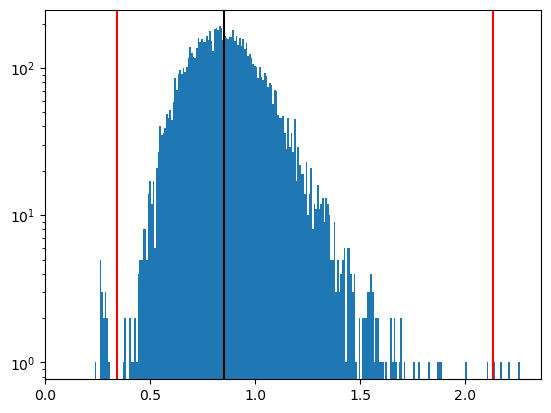

In [43]:
bins_sigma_z, hist_sigma_z, plot_sigma_z = plt.hist(
    spot_dataframe["sigma_z"], bins=256, log=True
)
median_z = spot_dataframe["sigma_z"].median()

fence_factor = 2.5
plt.axvline(x=median_z, color="k")
plt.axvline(x=median_z * fence_factor, color="r")
plt.axvline(x=median_z / fence_factor, color="r")

plt.xlim(0)

(0.0, 6.606712908080178)

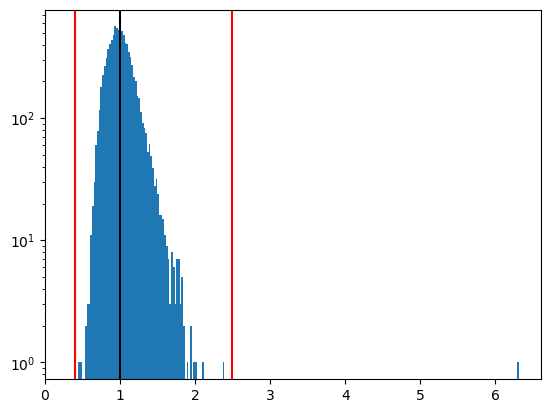

In [44]:
bins_sigma_x_y, hist_sigma_x_y, plot_sigma_x_y = plt.hist(
    spot_dataframe["sigma_x_y"], bins=256, log=True
)
median_x_y = spot_dataframe["sigma_x_y"].median()

fence_factor = 2.5
plt.axvline(x=median_x_y, color="k")
plt.axvline(x=median_x_y * fence_factor, color="r")
plt.axvline(x=median_x_y / fence_factor, color="r")
plt.xlim(0)

In [149]:
from utils import label_manipulation
import numpy as np


def _transfer_nuclear_labels_row(spot_dataframe_row, nuclear_labels):
    """
    Uses a provided nuclear mask to transfer the nuclear label of the nucleus
    containing the detected spot in a row of the spot dataframe output by
    :func"`~spot_analysis.detection`.
    """
    t_coordinate = spot_dataframe_row["frame"] - 1
    spatial_coordinates = (
        spot_dataframe_row[["z", "y", "x"]].astype(float).round().values
    )
    coordinates = np.array([t_coordinate, *spatial_coordinates], dtype=int)
    label = nuclear_labels[(*coordinates,)]
    return label


def transfer_nuclear_labels(
    spot_dataframe, nuclear_labels, expand_distance=1, client=None
):
    """
    Uses a provided nuclear mask to transfer the nuclear label of the nucleus
    containing each detected spot in the spot dataframe as output by
    :func"`~spot_analysis.detection`. If a `client` argument is passed, `nuclear_mask`
    may also be given as a list of futures as per the conventions of
    `utils.parallel_computing` for parallelization across a Dask LocalCluster. The input
    `spot_dataframe` is modified in-place to add a "particle" column with the
    corresponding labels.

    :param spot_dataframe: DataFrame containing information about putative spots as
        output by :func:`~spot_analysis.detection.detect_and_gather_spots`.
    :type spot_dataframe: pandas DataFrame
    :param nuclear_labels: Labelled movie of nuclear masks.
    :type nuclear_labels: Numpy array of integers
    :param int expand_distance: Euclidean distance in pixels by which to grow the labels,
        defaults to 1.
    :param client: Dask client to send the computation to.
    :type client: `dask.distributed.client.Client` object.
    :return: None
    :rtype: None
    """
    # Expand nuclear labels to spots at the very surface
    if client is None:
        expanded_labels = label_manipulation.expand_labels_movie(
            nuclear_labels, distance=expand_distance
        )
    else:
        expanded_labels, _, _ = label_manipulation.expand_labels_movie_parallel(
            nuclear_labels,
            distance=expand_distance,
            client=client,
            futures_in=False,
            futures_out=False,
            evaluate=True,
        )

    # Transfer labels from expanded nuclear mask to each spot
    spot_dataframe["particle"] = spot_dataframe.apply(
        _transfer_nuclear_labels_row, args=(expanded_labels,), axis=1
    )

    return None

In [132]:
%%time

transfer_nuclear_labels(
    spot_dataframe, reordered_labels_futures, expand_distance=2, client=client
)

CPU times: user 11.2 s, sys: 5.64 s, total: 16.8 s
Wall time: 24.2 s


In [135]:
extranuclear_spots = spot_dataframe[spot_dataframe["particle"] == 0]

(0.0, 2.3600081116039022)

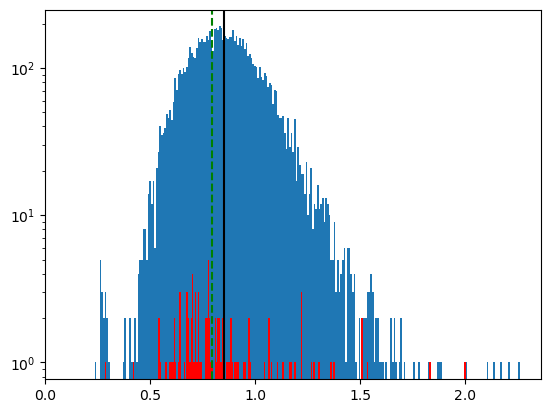

In [147]:
bins_sigma_z, hist_sigma_z, plot_sigma_z = plt.hist(
    spot_dataframe["sigma_z"], bins=256, log=True
)
median_z = spot_dataframe["sigma_z"].median()

fence_factor = 2.5
plt.axvline(x=median_z, color="k")

bins_sigma_z_ext, hist_sigma_z_ext, plot_sigma_z_ext = plt.hist(
    extranuclear_spots["sigma_z"], bins=256, log=True, color="r"
)
median_z_ext = extranuclear_spots["sigma_z"].median()
plt.axvline(x=median_z_ext, color="g", linestyle="--")

plt.xlim(0)

(0.0, 6.606712908080178)

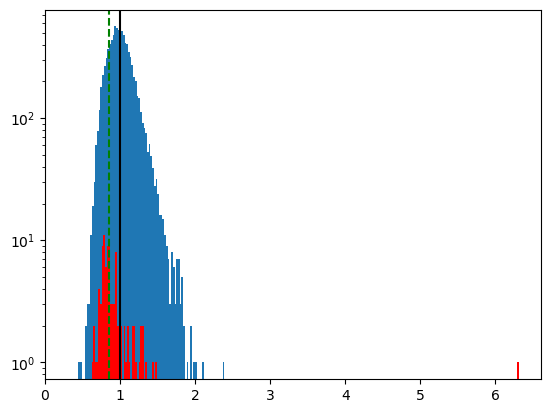

In [146]:
bins_sigma_x_y, hist_sigma_x_y, plot_sigma_x_y = plt.hist(
    spot_dataframe["sigma_x_y"], bins=256, log=True
)
median_x_y = spot_dataframe["sigma_x_y"].median()

fence_factor = 2.5
plt.axvline(x=median_x_y, color="k")

bins_sigma_x_y_ext, hist_sigma_x_y_ext, plot_sigma_x_y_ext = plt.hist(
    extranuclear_spots["sigma_x_y"], bins=256, log=True, color="r"
)
median_x_y_ext = extranuclear_spots["sigma_x_y"].median()
plt.axvline(x=median_x_y_ext, color="g", linestyle="--")

plt.xlim(0)

(0.0, 0.015462518017367331)

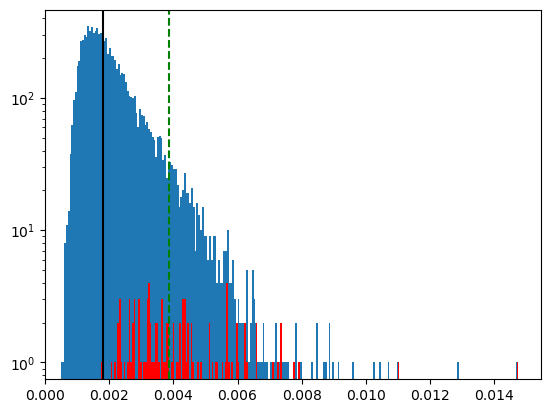

In [145]:
bins_norm_cost, hist_norm_cost, plot_norm_cost = plt.hist(
    spot_dataframe["norm_cost"], bins=256, log=True
)
median_norm_cost = spot_dataframe["norm_cost"].median()

fence_factor = 2.5
plt.axvline(x=median_norm_cost, color="k")

bins_norm_cost_ext, hist_norm_cost_ext, plot_norm_cost_ext = plt.hist(
    extranuclear_spots["norm_cost"], bins=256, log=True, color="r"
)
median_norm_cost_ext = extranuclear_spots["norm_cost"].median()
plt.axvline(x=median_norm_cost_ext, color="g", linestyle="--")

plt.xlim(0)

In [148]:
viewer.add_labels(spot_mask)

<Labels layer 'spot_mask' at 0x7fac595b2da0>

Given the ovelap of distributions of the normalized cost and standard deviations, it doesn't make sense to establish some sort of automatic thresholding based on computing the distributions. Instead we should implement a lax threshold based on physical feasibility of the parameters (e.g. using an estimate of the optical sectioning to remove spots with too small `sigma_z`). Based on the distributions above it doesn't look like this will clean up much.

Another approach to filtering is to track the spots independently, then use intersection-over-union of the tracking + nuclear tracking with some approach for deciding the extend of intersection (e.g. looking at the distance metric between ends of tracks within the same nucleus, or allowing spots that are part of traces above a certain threshold length, or a combination of that + taking into consideration `norm_cost`). A manual neighbor search can also be implemented if there aren't too many spurious spots.